# 7. Multi-Domain Grids and Quasinormal Modes

In [1]:
import numpy as np

from scipy.linalg import eig

import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 7.1 Multi-Domain Grids

Sometimes, one may need a very large number of points in the spectral computational grid. However, using a more than 128 points in a single domain is not recommended for numerical reasons. It is therefore useful to build multi-domain spectral grids, where several Chebyshev grids are concatenated one after another. 

The grid and differentiation matrices are built block-wise from properly scaled single domains. At the boundaries between domains, we choose to take the average between the values at both sides. Other choices are possible, of course. This way, by composing together $M$ grids of size $N+1$, we obtain a composite grid of size $M N + 1$, here given by the function `MultiDomain(M, N)`.

In [2]:
def ChebyshevD(N):
    row = np.arange(N + 1)[:, None]
    col = np.arange(N + 1)[None, :]
    x  = np.cos(np.pi * row / N)
    c  = ((1 + (col % N == 0)) * (-1) ** col).T
    X  = np.ones(N + 1) * x
    dX = X - X.T
    D  = c @ (1 / c.T) / (dX + np.eye(N + 1))
    D1 = D - np.diag(np.sum(D, axis=1))
    D2 = D1@D1
    return x, D1, D2

def MultiDomain(N, M):
    total_size = M * N + 1
    dx = 2.0 / M
    
    x, D1, D2 = ChebyshevD(N)
    bigx  = np.zeros((total_size, 1))
    bigD1 = np.zeros((total_size, total_size))
    bigD2 = np.zeros((total_size, total_size))
    
    for m in range(M):
        idx0, idx1 = m * N, m * N + (N + 1)
        bigx[ idx0:idx1, [0]]        = (x - 1) / M - dx * m + 1
        bigD1[idx0:idx1, idx0:idx1] += D1 * M
        bigD2[idx0:idx1, idx0:idx1] += D2 * M**2
        
        if m > 0:
            bigD1[idx0, :] /= 2
            bigD2[idx0, :] /= 2
            
    return bigx, bigD1, bigD2

As expected, the composite differentiation matrices are block-wise diagonal.

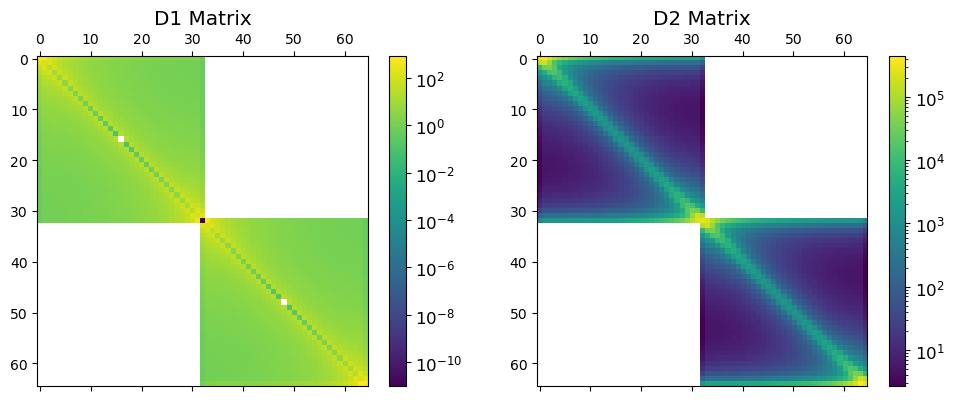

In [3]:
x, D1, D2 = MultiDomain(32, 2)

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].set_title('D1 Matrix')
pt0 = ax[0].matshow(np.abs(D1), norm = 'log')
plt.colorbar(pt0, ax = ax[0])

ax[1].set_title('D2 Matrix')
pt1 = ax[1].matshow(np.abs(D2), norm = 'log')
plt.colorbar(pt1, ax = ax[1])

plt.tight_layout()
################################################################################

Here we can test that the matrices are working as expected:

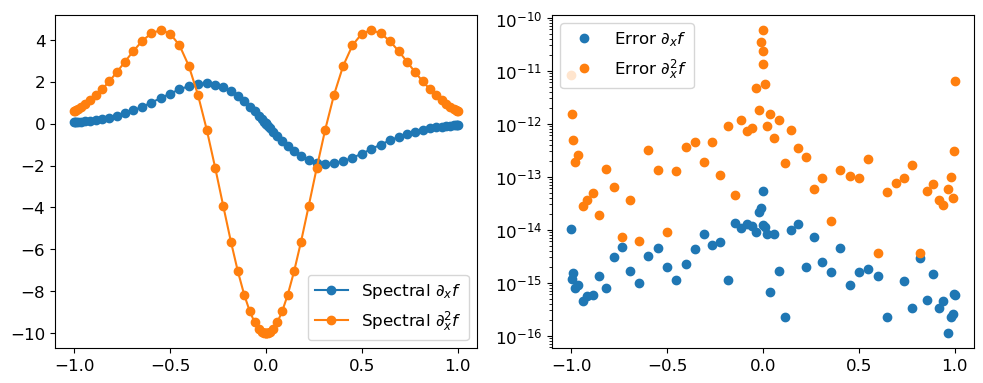

In [4]:
f   = np.exp( -5 * x**2 )
df  = - 10 * x * f
ddf = 10 * (10 * x**2 - 1) * f

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(x, D1 @ f, 'o-', label = r'Spectral $\partial_x f$', color = colors[0])
ax[0].plot(x, D2 @ f, 'o-', label = r'Spectral $\partial^2_x f$', color = colors[1])
ax[0].legend(loc = 'lower right')

ax[1].set_yscale('log')
ax[1].plot(x, np.abs(D1 @ f - df),  'o', label = r'Error $\partial_x f$', color = colors[0])
ax[1].plot(x, np.abs(D2 @ f - ddf), 'o', label = r'Error $\partial^2_x f$', color = colors[1])
ax[1].legend(loc = 'upper left')


plt.tight_layout()
################################################################################

This method is also useful when dealing with functions that are not smooth at some point, such as 

$$ f(x) = |x|\, . $$

If the boundary between domains coincides with the troublesome point, we can avoid the Gibbs phenomenon.

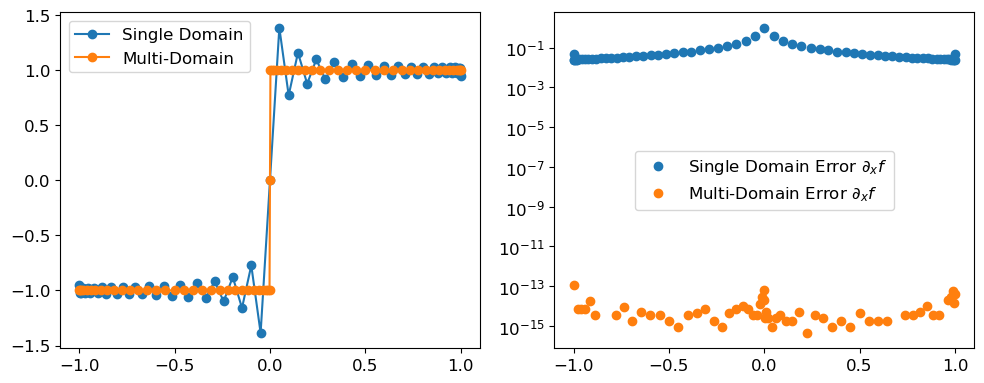

In [5]:

Sx, SD1, SD2 = ChebyshevD(64)
Mx, MD1, MD2 = MultiDomain(32, 2)

Sf, Sdf  = np.abs(Sx), np.sign(Sx)
Mf, Mdf  = np.abs(Mx), np.sign(Mx)

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,2, figsize = (10, 4));
plt.rc('font', size = 12)

ax[0].plot(Sx, SD1 @ Sf, 'o-', label = r'Single Domain', color = colors[0])
ax[0].plot(Mx, MD1 @ Mf, 'o-', label = r'Multi-Domain', color = colors[1])
ax[0].legend(loc = 'upper left')

ax[1].set_yscale('log')
ax[1].plot(Sx, np.abs(SD1 @ Sf - Sdf),  'o', label = r'Single Domain Error $\partial_x f$', color = colors[0])
ax[1].plot(Mx, np.abs(MD1 @ Mf - Mdf), 'o', label = r'Multi-Domain Error $\partial_x f$', color = colors[1])
ax[1].legend(loc = 'center')

plt.tight_layout()
################################################################################

## 7.2 Quasinormal and Spurious Modes

A special case of differential eigenvalue problems happens when the eigenvalues are complex. In this case, we solve for the first quasinormal modes of the Schwarzschild black hole. This is done by taking the Regge-Wheeler equation

$$  (r-1) \, r \, \psi ''(r)+\psi '(r) - \left[(l+1) l+\frac{\rho ^2 r^3}{r-1}-\frac{\epsilon }{r}\right]\, \psi (r)  = 0\, .$$

With $\epsilon = 3$, $l = 2$ and $\rho = - i \omega$. By removing the singular part at the boundaries and compactifying as

$$\psi (r) =  (r-1)^{\rho } r^{-2 \rho } e^{-\rho  (r-1)}  f(r) \, , \qquad  x = 1/r\, ,$$

we finally obtain
$$ (x-1) \, x^2 \, f''(x) + \left[ \left(2 - 4 x^2\right) i \omega +3 x^2-2 x \right] f'(x) + \left[ -4 (x + 1) \omega ^2-4 x i \omega + 6 -3 x\right] f(x) = 0 \, .$$

This contains terms with both $\omega$ and $\omega^2$, so the order has to be reduced. The details of this method are described in the excellent paper

> [**Overdamped modes in Schwarzschild-de Sitter and a Mathematica package for the numerical computation of quasinormal modes**](https://arxiv.org/abs/1709.09178)   
> Aron Jansen
> <br>**Eur.Phys.J.Plus 132 (2017) 12, 546**<br>
> https://arxiv.org/abs/1709.09178<br>

In other words, the discrete version of the differential equation has the form

$$ ( M_0 + \omega M_1 +  \omega^2 M_2 ) \cdot \psi = 0\, . $$ 

This can be rewritten in the standard eigenvalue form by defining

$$ M'_0 = \begin{pmatrix} M_0 & M_1 \\ 0 & I \\  \end{pmatrix}\, , \quad M'_1 = \begin{pmatrix} 0 & M_2 \\ -I & 0 \\  \end{pmatrix} \, , \quad \psi' =  \begin{pmatrix} \psi \\ \omega \, \psi \\ \end{pmatrix}\, ,$$

so that we get

$$ ( M'_0 + \omega M'_1 ) \cdot  \psi' = 0\, . $$

In [6]:
N = 16
x, D1, D2 = ChebyshevD(N - 1)

x  = (1 - x) / 2
xf = x.flatten()
I = np.eye(N)
D1 = - 2 * D1
D2 = + 4 * D2 

# Prepare the reduced order matrices 
M0 = np.zeros((2*N, 2*N), dtype = complex)
M1 = np.zeros((2*N, 2*N), dtype = complex)

M0[0*N:1*N, 0*N:1*N] = np.diag(6 - 3 * xf) @ I +            \
                       np.diag(3 * xf**2 - 2 * xf ) @ D1 +  \
                       np.diag((xf - 1) * xf**2) @ D2
M0[0*N:1*N, 1*N:2*N] = np.diag(- 4j * xf) @ I +            \
                       np.diag(2j - 4j * xf**2) @ D1
M0[1*N:2*N, 1*N:2*N] = I

M1[0*N:1*N, 1*N:2*N] = np.diag(- 4 * (1 + xf)) @ I
M1[1*N:2*N, 0*N:1*N] = -I


These modes can be compared to their values in the original paper by Edward W. Leaver:

> [**An analytic representation for the quasi-normal modes of Kerr black holes**](https://royalsocietypublishing.org/doi/10.1098/rspa.1985.0119)   
> Edward W. Leaver
> <br>**Proc.Roy.Soc.Lond.A 402 (1985) 285-298**<br>

Notice that we have to remove all the "spurious" modes with a real part too close to zero. This happens often in the calculation of quasinormal modes: Not all the modes that you get from the method are physical. Fortunately, this time they were easy to filter out.

In [7]:
# Solve the generalized eigenvalue problem
lam, V = eig(M0, - M1)

# Sort the eigenvalues and normalize
indices = np.argsort(- lam.imag)
indices = indices[lam[indices].real**2 > 0.1]  # Remove spurious modes
lam     = lam[indices]
V       = V[:, indices]

#Print some of the values
print('\nFirst modes:')
for i in range(5):
    w = lam[2*i]
    print(f'ω{i+1} = ± {np.abs(w.real):.6f} - {np.abs(w.imag):.6f} i')
print('...\n')


First modes:
ω1 = ± 0.747343 - 0.177925 i
ω2 = ± 0.693398 - 0.547873 i
ω3 = ± 0.603504 - 0.957793 i
ω4 = ± 0.516898 - 1.403926 i
ω5 = ± 0.442984 - 1.862647 i
...



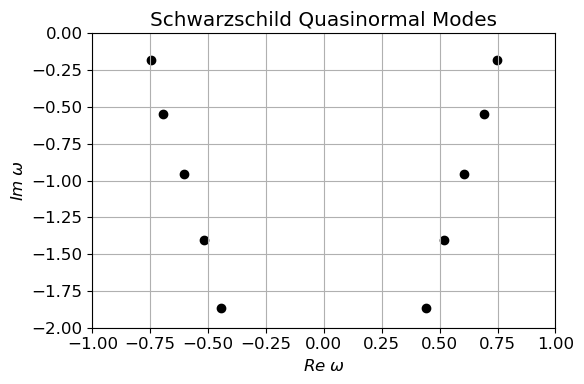

In [8]:
################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.scatter(lam.real, lam.imag, c = 'k')
ax.set_xlim(-1,1)
ax.set_ylim(-2,0)
ax.set_xlabel(r'$Re \; \omega$')
ax.set_ylabel(r'$Im \; \omega$')
ax.set_title(f'Schwarzschild Quasinormal Modes')
ax.grid()

plt.tight_layout()
################################################################################